# Clasificación de distintos modelos de coches de fabricantes varios usando modelos CNN

El objetivo del desarrollo de los distintos modelos CNN (Convolutional Neural Networks) es crear clasificadores de imágenes 
a partir de un set de datos, conteniendo este mismo distintas imágenes de varios ángulos de modelos variados de coches para poder
clasificar y distinguir entre ellos correctamente.

Dataset utilizado: [Car classification dataset](https://www.kaggle.com/datasets/boulahchichenadir/algerian-used-cars)

In [2]:
# --------------------------------------------------------------
#  Car classification with CNNs using PyTorch
# --------------------------------------------------------------

import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os
import time
from datetime import timedelta

# --------------------------  SEED  ---------------------------
SEED = 42

def set_seed(seed=SEED):
    """Reinicia todas las semillas para asegurar reproducibilidad"""
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Resetting seed to: {seed}")


set_seed(SEED)
# --------------------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
print("Using seed:", SEED)
# --------------------------------------------------------------

Resetting seed to: 42
Using device: cuda
Using seed: 42


In [3]:
# -----------------------  DEFAULT PARAMETERS  ------------------------
BATCH_SIZE       = 32   # tamaño de batch para DataLoader
IMAGE_SIZE       = 224  # imágenes de 224x224
BASE_LR          = 1e-3 # tasa de aprendizaje inicial
WEIGHT_DECAY     = 1e-4 # tasa de decaimiento de pesos
WARMPUP_EPOCHS   = 3    # número de epocas para warmup
EPOCHS_BASE      = 50   # numero de epocas para entrenamiento base
PATIENCE         = 8    # paciencia para early stopping
NEURONS          = 512  # numero de neuronas en la capa fully connected
# --------------------------------------------------------------
DATA_ROOT        = "./cars_dataset"
SELECTED_CLASSES = ["chevrolet-spark", "chevrolet-aveo", "golf", "polo", "toyota-corolla", "octavia", "logan"]
# --------------------------------------------------------------
TRAIN_TEST_SPLIT = 0.8  # 80%-20% train/test split
TRAIN_VAL_SPLIT  = 0.8  # 80%-20% train/val split
# --------------------------------------------------------------

Usaremos los valores por defecto definidos previamente para establecer una base sobre las que comparar todos los modelos que hemos desarrollado más adelante. Dado que el dataset nos proporciona imágenes de 224x224 pixeles, usaremos esa resolución a la hora de desarrollar la arquitectura de nuestros modelos CNN.

Usaremos como tasa de aprendizaje base `1e-3`, bajando a `1e-4` a la hora de usar aprendizaje mediante transferencia. Este cambio lo discutiremos más adelante para ver como afecta a la tasa de aprendizaje del modelo.

El parámetro `WEIGHT_DECAY` o tasa de decadencia de pesos nos permitirá penalizar los pesos más grandes del modelo, lo cual ayuda a evitar el *overfitting*.

Por último, los parámetros de `WARMUP_EPOCHS, EPOCHS_BASE, PATIENCE` nos permitirá:
- `WARMUP_EPOCHS`: una tasa de aprendizaje acelerada varios bucles antes de que nuestro regulador de tasa de aprendizaje actúe.
- `EPOCHS_BASE`: establecer la cantidad de épocas que necesite el modelo para entrenar.
- `PATIENCE`: establecer cuanta paciencia tendrá el entrenamiento del modelo antes de forzar una terminación temprana del entrenamiento. 

Este último parámetro viene ligado a una técnica conocida como *Early Stopping*, la cual mide la mejora del modelo época a época, y decide terminar de forma temprana el entrenamiento del modelo si ve que las métricas como la precisión o pérdida del modelo no mejoran tras un número de épocas transcurridas, definidas en `PATIENCE`. Para nuestro entrenamiento, usaremos `dev_loss` para medir cuando tiene que ocurrir la *parada temprana* del entrenamiento. El uso de técnicas como el *early stopping* nos permite prevenir ocurrencias de *overfitting* a la hora de enternar nuestros modelos.

In [4]:
class ModelParams:
    def __init__(self, 
                 learning_rate=BASE_LR,
                 weight_decay=WEIGHT_DECAY,
                 warmup_epochs=WARMPUP_EPOCHS,
                 training_epochs=EPOCHS_BASE,
                 patience=PATIENCE,
                 neurons=NEURONS, 
                 label=None):
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.warmup_epochs = warmup_epochs
        self.training_epochs = training_epochs
        self.patience = patience
        self.neurons = neurons
        self.label = label
        
    def __str__(self):
        return (f"[learning_rate={self.learning_rate}, weight_decay={self.weight_decay}, "
                f"warmup_epochs={self.warmup_epochs}, training_epochs={self.training_epochs}, "
                f"patience={self.patience}, neurons={self.neurons}]")
        
DEFAULT_MODEL_PARAMS = ModelParams()

Esta clase de ayuda nos permitirá cambiar los parámetros de los modelos de forma facil, para hacer comparaciones rápidas con un mismo modelo y diferentes parámetros de aprendizaje.

Dentro de nuestro dataset, podemos ver una cantidad variada de modelos de coches y de distintos fabricantes. Para esta demonstración, pondremos como restricción solo entrenar los modelos en base a aquellas clases en las que dispongamos de al menos **100 imágenes** de datos.

Podemos modificar que clases queremos incluir dentro del entrenamiento de nuestro modelo usando la lista de `SELECTED_CLASSES`.

| #  | Name of class         | Number of files |
|----|-----------------------|-----------------|
| 1  | bmw-serie-1           | 82              |
| 2  | chevrolet-spark       | 108             |
| 3  | chevrolet-aveo        | 129             |
| 4  | clio                  | 344             |
| 5  | duster                | 280             |
| 6  | golf                  | 160             |
| 7  | hyundai-i10           | 130             |
| 8  | hyundai-tucson        | 128             |
| 9  | logan                 | 112             |
| 10 | megane                | 280             |
| 11 | mercedes-class-a      | 84              |
| 12 | nemo-citroen          | 80              |
| 13 | octavia               | 156             |
| 14 | picanto               | 178             |
| 15 | polo                  | 132             |
| 16 | sandero               | 260             |
| 17 | seat-ibiza            | 100             |
| 18 | symbol                | 158             |
| 19 | toyota-corolla        | 150             |
| 20 | volkswagen-tiguan     | 184             |

Para esta demonstración, hemos escogido en conjunto las clases de `polo` y `golf`, dado que son del mismo fabricante (Volkswagen) y sus carrocerías son muy similares, lo cual nos permitirá evaluar que tan preciso es el modelo a la hora de distinguir dos clases similares.

Esto nos daria un buen indicador de que capacidades dispone el modelo de diferenciar entre dos modelos de coches tan similares usando los diferentes mapas de caracteristicas que creara el modelo, dependiendo de su arquitectura.

In [5]:
# -----------------------  TRANSFORMS  ------------------------
# https://docs.pytorch.org/vision/stable/transforms.html#torchvision.transforms.Normalize
# for normalization, we use the standard ImageNet values
mean_values = [0.485, 0.456, 0.406]  # ImageNet mean values for normalization
std_values  = [0.229, 0.224, 0.225]  # ImageNet std values for normalization

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # redimensiona la imagen
    transforms.RandomHorizontalFlip(p=0.5),  # voltea horizontalmente con probabilidad 0.5
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),  # recorte y escalado aleatorio
    transforms.RandomRotation(degrees=10),  # rotación a la imagen aleatoria
    transforms.ColorJitter(hue=0.15, brightness=0.2, contrast=0.2, saturation=0.2),  # altera color/contraste/tono
    transforms.ToTensor(),  # convierte PIL->Tensor y normaliza rango [0,1]
    transforms.Normalize(mean=mean_values,  # normaliza con medias de ImageNet
                         std=std_values),  # desviaciones estándar de ImageNet
])

test_transform = transforms.Compose([  # transformaciones para validación/prueba (determinísticas)
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # redimensiona al tamaño objetivo
    transforms.ToTensor(),  # convierte a tensor
    transforms.Normalize(mean=mean_values,  # normaliza con medias ImageNet
                         std=std_values),  # normaliza con std ImageNet
])

# --------------------------------------------------------------

Para entrenar nuestros modelos, aplicaremos ciertas transformaciones a nuestras imágenes del conjunto de entrenamiento. Principalmente, esta transformacion nos permite convertir los datos de una imagen a un tensor. Para las imágenes, la representacion de un tensor seria tal que [canales, alto, ancho], donde los canales serian RGB.

Ademas de convertir la imagen a un tensor, aplicaremos transformaciones adicionales como `RandomHorizontalFlip, RandomResizedCrop, RandomRotation, ColorJitter`, los cuales invierten horizontalmente la imagen, rescalan la imagen, rotan la imagen y cambian los colores y saturaciones de la imagen de forma aleatoria antes de convertirla en un tensor. Estas variaciones en las imágenes originales del datast ayuda al modelo a mejorar su capacidad de generalizacion.

Cabe destacar que las transformaciones excluyendo la del tensor solo se aplican en el set de datos de entrenamiento. A la hora de evaluar o poner aprueba el modelo, las unicas transformaciones que aplicamos son aquellas de rescalado correcto de imagen y conversiones a formato tensor.

In [6]:
from PIL import Image

class CarImageDataset(Dataset):
    """
    Set de datos personalizado para imágenes de coches.
    
    Aplica transformaciones a las imágenes y devuelve pares (imagen, etiqueta).
    """
    
    def __init__(self, image_paths, labels, class_to_idx, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
            
        return img, label

In [7]:
from sklearn.model_selection import train_test_split
import glob

def create_datasets(root_dir, selected_classes, train_transform, test_transform):
    """
    Crea conjuntos de datos de entrenamiento, validación y prueba a partir de un 
    directorio raíz y clases seleccionadas.
    """
    
    all_paths = []
    all_labels = []
    
    class_to_idx = {cls_name: i for i, cls_name in enumerate(selected_classes)}
    
    print(f"Loading specific classes: {selected_classes}...")

    for cls_name in selected_classes:
        class_dir = os.path.join(root_dir, cls_name)
        
        # find all files for png, jpg, ...
        files = glob.glob(os.path.join(class_dir, "*.*")) 
        files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        
        if len(files) == 0:
            print(f"Warning: No images found for {cls_name}")
            continue
            
        all_paths.extend(files)
        all_labels.extend([class_to_idx[cls_name]] * len(files))
        
        print(f"Found {len(files)} images for class '{cls_name}'")

    print(f"Total images found: {len(all_paths)}")

    # train-test split
    train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
        all_paths, all_labels, 
        test_size=1-TRAIN_TEST_SPLIT, 
        stratify=all_labels,
        random_state=SEED
    )

    # train-val split
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_val_paths, train_val_labels, 
        test_size=1-TRAIN_VAL_SPLIT,
        stratify=train_val_labels,
        random_state=SEED
    )

    train_ds = CarImageDataset(train_paths, train_labels, class_to_idx, transform=train_transform)
    val_ds   = CarImageDataset(val_paths, val_labels, class_to_idx, transform=test_transform)
    test_ds  = CarImageDataset(test_paths, test_labels, class_to_idx, transform=test_transform)

    return train_ds, val_ds, test_ds

Partiendo del dataset completo inicial, filtramos las categorias que hemos seleccionado y los partiremos de la siguiente forma:
1. Usando el metodo `create_datasets` aseguraremos una division de datos equitativa entre los sets de entrenamiento, validacion y test
2. La division de estas tres categorias se dividira usando `TRAIN_TEST_SPLIT` para dividir un porcentaje de los datos totales en sets de entrenamiento y test
3. A partir del set de entrenamiento, partiremos de nuevo este set en dos usando `TRAIN_VAL_SPLIT` para obtener el set final de entrenamiento y un set de validacion
4. Una vez separados en estas tres categorias de forma aleatoria (aleatoriedad controlada usando `SEED`), aplicaremos nuestra implementacion del `CarImageDataset` que nos permitirá aplicar los transformadores de imagen previamente definidos a las imágenes los datasets de estas categorias.

In [8]:
train_set, val_set, test_set = create_datasets(
    root_dir=DATA_ROOT,
    selected_classes=SELECTED_CLASSES,
    train_transform=train_transform,
    test_transform=test_transform # usamos la misma transformación para validacion y test
)

from collections import Counter # Verificamos la distribución de clases
print("\n--- Distribution Check ---")
print(f"Train size: {len(train_set)}")
print(f"Validation size:   {len(val_set)}")
print(f"Test size:  {len(test_set)}")
print("Test Set Class Counts:", sorted(Counter([y for _, y in test_set]).items()))

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

Loading specific classes: ['chevrolet-spark', 'chevrolet-aveo', 'golf', 'polo', 'toyota-corolla', 'octavia', 'logan']...
Found 108 images for class 'chevrolet-spark'
Found 129 images for class 'chevrolet-aveo'
Found 160 images for class 'golf'
Found 132 images for class 'polo'
Found 150 images for class 'toyota-corolla'
Found 156 images for class 'octavia'
Found 112 images for class 'logan'
Total images found: 947

--- Distribution Check ---
Train size: 605
Validation size:   152
Test size:  190
Test Set Class Counts: [(0, 22), (1, 26), (2, 32), (3, 27), (4, 30), (5, 31), (6, 22)]


In [9]:
def plot_loader_data(loader):
    fig, axes = plt.subplots(1, len(SELECTED_CLASSES), figsize=(15, 5))
    shown_classes = set()
    shown_indices = []
    print("Image size: ", loader.dataset[0][0].shape)

    for idx, (img, label) in enumerate(loader.dataset):
        class_name = SELECTED_CLASSES[label]
        if class_name not in shown_classes:
            shown_classes.add(class_name)
            shown_indices.append(idx)
        if len(shown_indices) == len(SELECTED_CLASSES):
            break

    for ax, idx in zip(axes, shown_indices):
        img, label = loader.dataset[idx]
        image = img.permute(1, 2, 0)
        denormalized_img = image * torch.tensor(std_values) + torch.tensor(mean_values)
        ax.imshow(denormalized_img)
        ax.set_title(SELECTED_CLASSES[label])
        ax.axis('off')

    plt.show()

Image size:  torch.Size([3, 224, 224])


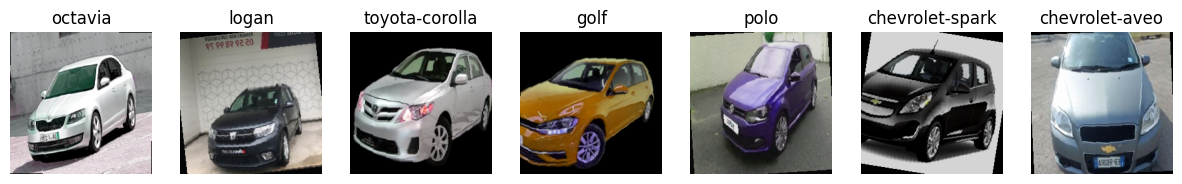

In [9]:
# TRAIN SET SAMPLE VISUALIZATION
plot_loader_data(train_loader)

Esta toma de prueba de imágenes es aquella que esta contenida dentro de nuestro dataset de entrenamiento.

Podemos apreciar aquellas transformaciones que hemos definido en la transformacion de entrenamiento:
- Rotacion aleatoria
- Cambios de color, luminosidad y saturacion
- Recortes y rescalados aleatorios

Image size:  torch.Size([3, 224, 224])


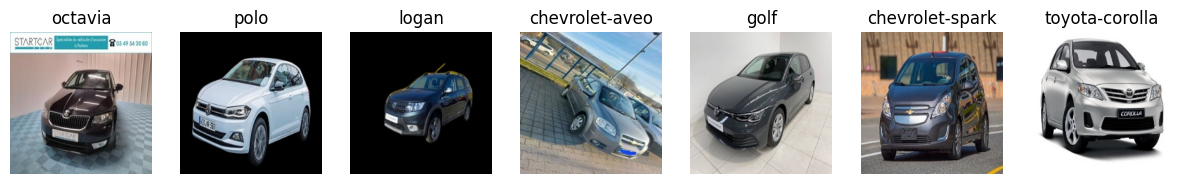

In [10]:
# TEST SET SAMPLE VISUALIZATION
plot_loader_data(test_loader)

Cabe destacar que para poder visualizar las imágenes dentro de los datasets, debemos utilizar los valores de `mean` y `std` previamente definidos para de-normalizar las imágenes. Esto nos permitirá revertir la transformacion de normalizacion aplicada en el dataset y pasarlos a valores comprendidos entre [0, 255].

In [11]:
class ClassifierCNN(nn.Module):
    def __init__(self, neurons):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(512 * (IMAGE_SIZE // 32) * (IMAGE_SIZE // 32), neurons)
        self.bnfc = nn.BatchNorm1d(neurons)
        self.fc2 = nn.Linear(neurons, len(SELECTED_CLASSES))
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x)))) # 224 -> 112
        x = self.pool(F.relu(self.bn2(self.conv2(x)))) # 112 -> 56
        x = self.pool(F.relu(self.bn3(self.conv3(x)))) # 56 -> 28
        x = self.pool(F.relu(self.bn4(self.conv4(x)))) # 28 -> 14
        x = self.pool(F.relu(self.bn5(self.conv5(x)))) # 14 -> 7
        
        x = x.view(x.size(0), -1)  # flatten
        
        x = self.dropout(F.relu(self.bnfc(self.fc1(x))))
        x = self.fc2(x)
        
        return x

Este modelo sirve de esquema inicial a un diseño estandarizado a la hora de arquitecturar un modelo convolucional de clasificacion de imágenes.

Usamos 5 bloques convolucionales, los cuales poseen:
- Un componente de convolucion para extraccion de caracteristicas
- Un componente de normalizacion en grupo (`BatchNorm`) para estabilizar el entrenamiento
- La funcion de activacion ReLU, al ser más eficiente que la Softmax
- Un componente `MaxPool` que reduce los valores en la mascara del kernel al máximo entre ellos

Por último, tenemos la capa de clasificacion la cual aplanamos los tensores a un vector muy grande para procesarlo dentro la red neuronal *fully connected*, para terminar con el numero de capas de salida igual al numero de clases con el que queremos clasificar. Cabe destacar el componente de `Dropout`, que nos ayuda a apagar neuronas aleatoriamente (50%) y evitar que el modelo memorice rigidamente las imágenes de entrenamiento y lo ayude a generalizar las caracteristicas.

In [12]:
class SequentialClassifierCNN(nn.Module):
    def __init__(self, neurons):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 224 -> 112
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 112 -> 56
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 56 -> 28
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 28 -> 14
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 14 -> 7
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * (IMAGE_SIZE // 32) * (IMAGE_SIZE // 32), neurons),
            nn.BatchNorm1d(neurons),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(neurons, len(SELECTED_CLASSES)),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

Adicionalmente, hemos replicado el mismo modelo usando el modulo `Sequential`, que nos permite definir la arquitectura del modelo de forma más limpia y modular. 
En este modelo, agrupamos los componentes en dos modulos: modulo de extraccion de caracteristicas y otro de clasificacion.

In [13]:
class LimitedCNN(nn.Module):
    def __init__(self, neurons):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (IMAGE_SIZE // 8) * (IMAGE_SIZE // 8), neurons),
            nn.BatchNorm1d(neurons),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(neurons, len(SELECTED_CLASSES))
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

El modelo `LimitedCNN` esta arquitecturado intencionalmente con menos capas convolucionales de extraccion de caracteristicas, y muchas menos neuronas en comparacion con los modelos `ClassifierCNN` o `SequentialClassifierCNN`. 

Las principales limitaciones presentes son la profundidad de los canales, siendo la final de 64, mientras que las otras tenian 512 canales finales. Se pretende demonstrar con este modelo como, al tener menos capas y neuronas, no es capaz de extraer patrones tan complejos o abstractos de los coches. Esto implicaria que si al diseñar nuestra red, su arquitectura es muy simple frente a la necesidad de categorizar detalles claves (como parachoques, fabricantes, luces...), la precision del modelo se deberia estancar.

In [10]:
# ---------------------  TRAINING HELPERS  --------------------
def evaluate(model, loader, criterion):
    model.eval()
    
    running_loss = 0.0
    running_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            batch_size = inputs.size(0)
            running_loss += loss.item() * batch_size
            
            _, preds = torch.max(outputs, 1)
            running_correct += torch.sum(preds == labels.data).item()
            total_samples += batch_size
    
    avg_loss = running_loss / total_samples
    accuracy = 100.0 * running_correct / total_samples
    
    return avg_loss, accuracy

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    
    running_loss = 0.0
    running_correct = 0
    total_samples = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        batch_size = inputs.size(0)
        running_loss += loss.item() * batch_size 
        
        _, preds = torch.max(outputs, 1)
        running_correct += torch.sum(preds == labels.data).item()
        total_samples += batch_size

    epoch_loss = running_loss / total_samples
    epoch_acc = 100.0 * running_correct / total_samples
    
    return epoch_loss, epoch_acc
    
# --------------------------------------------------------------

Definimos los metodos que usaremos para entrenar el modelo epoca por epoca, y ademas como evaluaremos el modelo, usando tanto el dataset de evaluacion como el de test.

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, loader, class_names, model_name="Model"):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(DEVICE)
            out = model(inputs)
            preds = out.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()

def plot_training_history(h, model_name="Model"):
    ep = range(1, len(h["train_loss"]) + 1)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(ep, h["train_loss"], label="train")
    plt.plot(ep, h["dev_loss"],   label="dev")
    plt.title(f"{model_name} - Loss"); plt.xlabel("Epoch"); plt.legend(); plt.grid()
    plt.subplot(1,2,2)
    plt.plot(ep, h["train_acc"], label="train")
    plt.plot(ep, h["dev_acc"],   label="dev")
    plt.title(f"{model_name} - Accuracy (%)"); plt.xlabel("Epoch"); plt.legend(); plt.grid()
    plt.tight_layout(); plt.show()

Como metricas adicionales, usaremos dos graficas para plasmar la perdida del modelo y la precision del modelo a lo largo de su entrenamiento, junto a una matriz de confusion.

La matriz de confusion es una grafica en forma de matriz, con ejes referenciados a las clases seleccionadas, que nos permite ver como el modelo clasifico las imágenes con las que se le puso a prueba. Una grafica de matriz de confusion optima mostraria la densidad maxima posible en la diagonal de la matriz, plasmando como el modelo posee 100% de precision a la hora de clasificar las imágenes que se le insertan. Dado que no siempre sera el caso, esperamos ver como ciertas celdas fuera de la diagonal se dotan de valores, indicando en que clases se ha confundido el modelo a la hora de clasificar.

In [12]:
def train_model(ModelClass, model_params: ModelParams, transfer_learning=False):
    set_seed(SEED)
    
    if transfer_learning:
        model = ModelClass.to(DEVICE)
        print("Training via Transfer Learning")
    else:
        model = ModelClass(neurons=model_params.neurons).to(DEVICE)
    
    if model_params.label is None:
        model_name = model.__class__.__name__
    else:
        model_name = f"{model.__class__.__name__}_{model_params.label}"
    
    print("Training model:", model_name)
    print("Training parameters:", model_params)
    
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.Adam(model.parameters(), lr=model_params.learning_rate, weight_decay=model_params.weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=model_params.training_epochs)

    history = {"train_loss": [], "train_acc": [], "dev_loss": [], "dev_acc": []}

    best_dev_loss = float('inf')
    wait = 0

    start_time = time.time()
    print("Starting training at: ", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time)))
    
    for epoch in range(1, model_params.training_epochs + 1):
        epoch_start = time.time()
        
        if epoch <= model_params.warmup_epochs:
            lr = model_params.learning_rate * (epoch / model_params.warmup_epochs)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        
        if epoch > model_params.warmup_epochs:
            scheduler.step()
            
        dev_loss, dev_acc = evaluate(model, val_loader, criterion)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["dev_loss"].append(dev_loss)
        history["dev_acc"].append(dev_acc)

        epoch_time = time.time() - epoch_start
        
        if epoch % 5 == 0:
            print(f"[Epoch {epoch:02d} | LR] Current LR:", optimizer.param_groups[0]['lr'])
        
        if dev_loss < best_dev_loss:
            best_dev_loss = dev_loss
            torch.save(model.state_dict(), f'models/{model_name}_best_model.pth')
            wait = 0
        else:
            wait += 1

        print(f"[Epoch {epoch:02d} | {epoch_time:.2f}s | p={wait}/{PATIENCE}] "
            f"train_loss: {tr_loss:.3f} | train_acc: {tr_acc:5.2f}% | "
            f"dev_loss: {dev_loss:.3f} | dev_acc: {dev_acc:5.2f}%")

        if wait >= PATIENCE:
            print(f"Early stopping triggered at epoch {epoch}.")
            break

    total_time = time.time() - start_time
    print(f"\n=== TOTAL TRAINING TIME: {timedelta(seconds=int(total_time))} ({total_time:.2f}s) ===")

    print("\nLoading best model for final testing...")
    model.load_state_dict(torch.load(f'models/{model_name}_best_model.pth'))
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    print(f"=== FINAL TEST ACCURACY: {test_acc:.2f}% ===")

    plot_training_history(history, model_name=model_name)
    plot_confusion_matrix(model, test_loader, SELECTED_CLASSES, model_name=model_name)

A la hora de ejecutar el bucle de entrenamiento, usaremos:
- Funcion de perdida (`criterion`): `CrossEntropyLoss`. Este componente se encarga de evaluar que tan mal o bien lo esta haciendo el modelo en cada paso del entrenamiento.
- Optimizador de pesos (`optimizer`): `Adam`. Este componente ira ajustando progresivamente los pesos de la red neuronal basandose en el error calculado por `criterion`. `Adam`, siendo estandar en la industria de la inteligencia artificial, ajusta cada parámetro de la red de forma individual: si una neurona aprende rapido la frena, y viceversa.
- Planificador de tasa de aprendizaje (`scheduler`): `CosineAnnealingLR`. Este planificador hace que la tasa de aprendizaje empiece alta y vaya bajando suavemente siguiendo una curva de coseno hasta llegar a casi cero. Es lo más correcto para atajar un aprendizaje rapido al principio de la red, y lento a medida que aprende y el modelo memoriza los detalles.

Cabe destacar que aun disponiendo de un *scheduler*, dotamos de la tecnica de epocas de calentamiento (`WARMUP_EPOCHS`), que nos permite ajustar que tan temprano o tan tarde queremos que empiece a planificar la tasa de aprendizaje el *scheduler* seleccionado.

Resetting seed to: 42
Training model: ClassifierCNN
Training parameters: [learning_rate=0.001, weight_decay=0.0001, warmup_epochs=3, training_epochs=50, patience=8, neurons=512]
Starting training at:  2025-12-19 09:50:19
[Epoch 01 | 6.09s | p=0/8] train_loss: 1.981 | train_acc: 27.77% | dev_loss: 2.151 | dev_acc: 13.82%
[Epoch 02 | 4.41s | p=0/8] train_loss: 1.686 | train_acc: 38.84% | dev_loss: 1.817 | dev_acc: 35.53%
[Epoch 03 | 4.47s | p=1/8] train_loss: 1.627 | train_acc: 43.80% | dev_loss: 1.909 | dev_acc: 33.55%
[Epoch 04 | 4.46s | p=0/8] train_loss: 1.452 | train_acc: 51.74% | dev_loss: 1.558 | dev_acc: 40.79%
[Epoch 05 | LR] Current LR: 0.000996057350657239
[Epoch 05 | 4.50s | p=1/8] train_loss: 1.362 | train_acc: 56.53% | dev_loss: 1.906 | dev_acc: 35.53%
[Epoch 06 | 4.15s | p=2/8] train_loss: 1.215 | train_acc: 65.29% | dev_loss: 1.676 | dev_acc: 46.71%
[Epoch 07 | 4.81s | p=0/8] train_loss: 1.188 | train_acc: 67.93% | dev_loss: 1.280 | dev_acc: 53.95%
[Epoch 08 | 4.75s | p=1

C:\Users\Cristina\AppData\Local\Temp\ipykernel_3896\1521683971.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/{model_name}_be

=== FINAL TEST ACCURACY: 97.89% ===


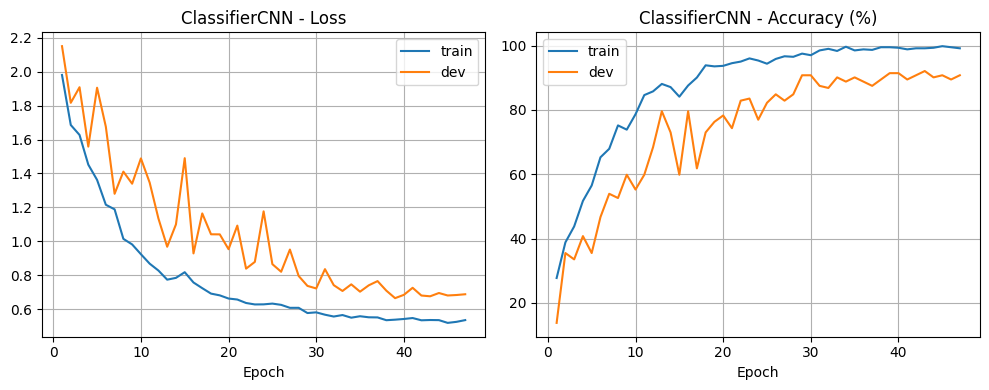

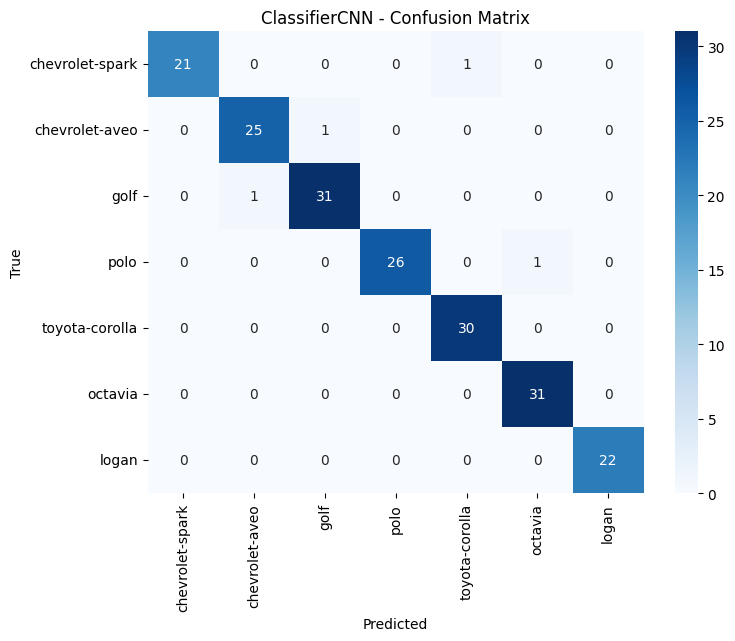

In [17]:
# --------------------------  TRAIN  ---------------------------
train_model(ClassifierCNN, DEFAULT_MODEL_PARAMS)

Resetting seed to: 42
Training model: SequentialClassifierCNN
Training parameters: [learning_rate=0.001, weight_decay=0.0001, warmup_epochs=3, training_epochs=50, patience=8, neurons=512]
Starting training at:  2025-12-19 09:53:58
[Epoch 01 | 4.54s | p=0/8] train_loss: 1.981 | train_acc: 27.77% | dev_loss: 2.151 | dev_acc: 13.82%
[Epoch 02 | 4.39s | p=0/8] train_loss: 1.686 | train_acc: 38.84% | dev_loss: 1.817 | dev_acc: 35.53%
[Epoch 03 | 4.54s | p=1/8] train_loss: 1.627 | train_acc: 43.80% | dev_loss: 1.909 | dev_acc: 33.55%
[Epoch 04 | 4.26s | p=0/8] train_loss: 1.452 | train_acc: 51.74% | dev_loss: 1.558 | dev_acc: 40.79%
[Epoch 05 | LR] Current LR: 0.000996057350657239
[Epoch 05 | 4.35s | p=1/8] train_loss: 1.362 | train_acc: 56.53% | dev_loss: 1.906 | dev_acc: 35.53%
[Epoch 06 | 4.41s | p=2/8] train_loss: 1.215 | train_acc: 65.29% | dev_loss: 1.676 | dev_acc: 46.71%
[Epoch 07 | 4.27s | p=0/8] train_loss: 1.188 | train_acc: 67.93% | dev_loss: 1.280 | dev_acc: 53.95%
[Epoch 08 | 4

C:\Users\Cristina\AppData\Local\Temp\ipykernel_3896\1521683971.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/{model_name}_be

=== FINAL TEST ACCURACY: 97.89% ===


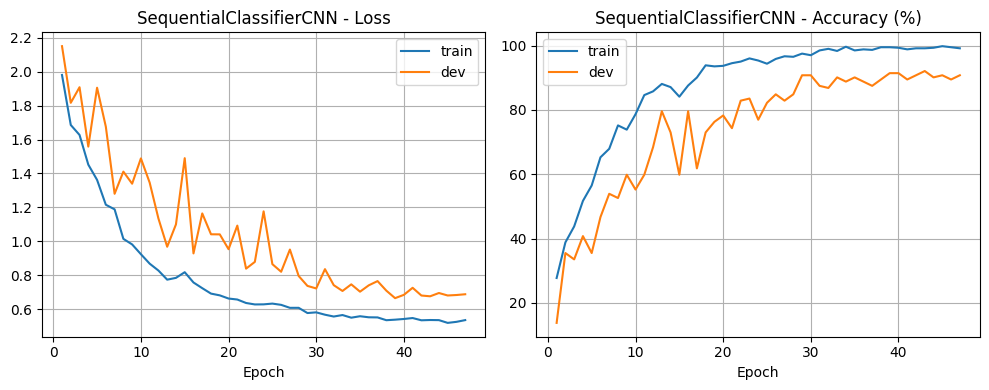

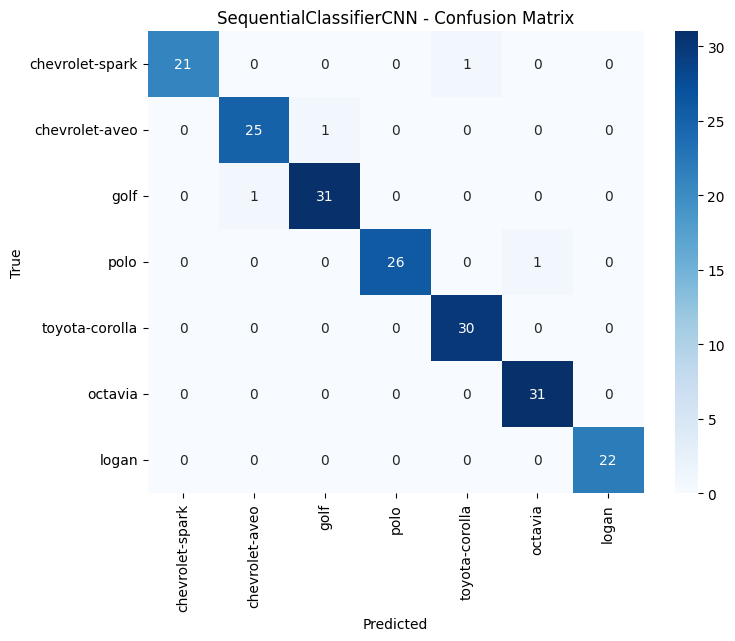

In [18]:
train_model(SequentialClassifierCNN, DEFAULT_MODEL_PARAMS)

Resetting seed to: 42
Training model: SequentialClassifierCNN_LowerNeurons256
Training parameters: [learning_rate=0.0001, weight_decay=0.0001, warmup_epochs=3, training_epochs=50, patience=8, neurons=256]
Starting training at:  2025-12-19 11:06:11
[Epoch 01 | 4.57s | p=0/8] train_loss: 1.923 | train_acc: 22.31% | dev_loss: 1.983 | dev_acc: 15.79%
[Epoch 02 | 4.59s | p=0/8] train_loss: 1.723 | train_acc: 38.02% | dev_loss: 1.680 | dev_acc: 44.08%
[Epoch 03 | 4.57s | p=1/8] train_loss: 1.615 | train_acc: 43.80% | dev_loss: 1.688 | dev_acc: 41.45%
[Epoch 04 | 4.56s | p=0/8] train_loss: 1.545 | train_acc: 46.94% | dev_loss: 1.517 | dev_acc: 46.05%
[Epoch 05 | LR] Current LR: 9.96057350657239e-05
[Epoch 05 | 4.61s | p=0/8] train_loss: 1.427 | train_acc: 53.88% | dev_loss: 1.495 | dev_acc: 50.00%
[Epoch 06 | 4.51s | p=0/8] train_loss: 1.364 | train_acc: 56.03% | dev_loss: 1.412 | dev_acc: 52.63%
[Epoch 07 | 4.51s | p=0/8] train_loss: 1.292 | train_acc: 65.45% | dev_loss: 1.386 | dev_acc: 55.

C:\Users\Cristina\AppData\Local\Temp\ipykernel_1432\1521683971.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/{model_name}_be

=== FINAL TEST ACCURACY: 90.53% ===


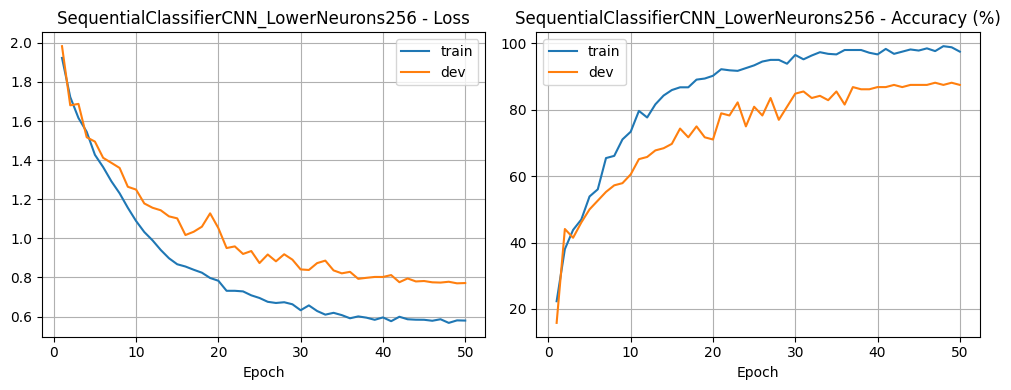

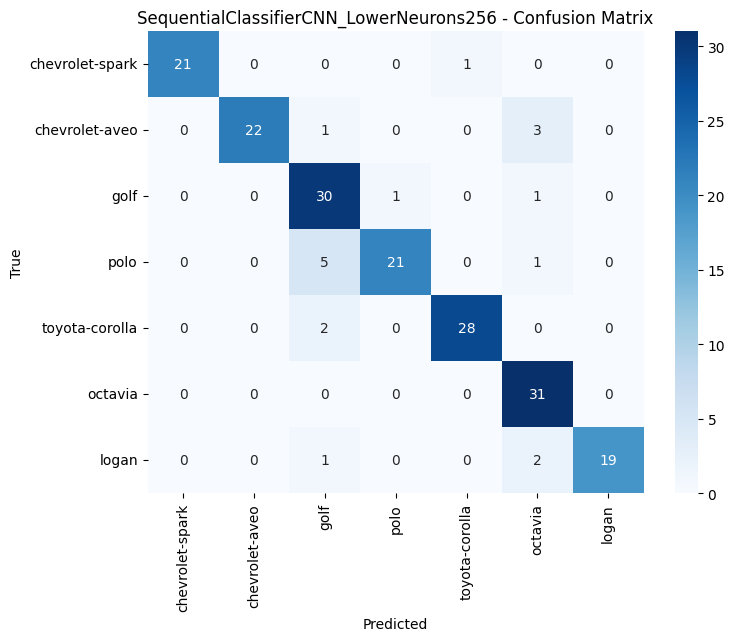

In [18]:
low_model_params = ModelParams(
    learning_rate=1e-4,
    neurons=256,
    label="LowerNeurons256"
)

train_model(SequentialClassifierCNN, low_model_params)

Resetting seed to: 42
Training model: SequentialClassifierCNN_LowerNeurons128
Training parameters: [learning_rate=1e-05, weight_decay=0.0001, warmup_epochs=3, training_epochs=50, patience=8, neurons=128]
Starting training at:  2025-12-19 10:06:03
[Epoch 01 | 4.69s | p=0/8] train_loss: 2.071 | train_acc: 13.55% | dev_loss: 1.989 | dev_acc: 11.18%
[Epoch 02 | 4.79s | p=0/8] train_loss: 1.999 | train_acc: 20.00% | dev_loss: 1.887 | dev_acc: 30.92%
[Epoch 03 | 4.85s | p=0/8] train_loss: 1.902 | train_acc: 26.28% | dev_loss: 1.808 | dev_acc: 26.32%
[Epoch 04 | 4.80s | p=0/8] train_loss: 1.854 | train_acc: 28.26% | dev_loss: 1.752 | dev_acc: 35.53%
[Epoch 05 | LR] Current LR: 9.960573506572391e-06
[Epoch 05 | 4.54s | p=0/8] train_loss: 1.831 | train_acc: 31.40% | dev_loss: 1.723 | dev_acc: 37.50%
[Epoch 06 | 5.37s | p=0/8] train_loss: 1.755 | train_acc: 33.88% | dev_loss: 1.705 | dev_acc: 39.47%
[Epoch 07 | 5.17s | p=0/8] train_loss: 1.715 | train_acc: 35.54% | dev_loss: 1.671 | dev_acc: 40.

C:\Users\Cristina\AppData\Local\Temp\ipykernel_3896\1521683971.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/{model_name}_be

=== FINAL TEST ACCURACY: 61.58% ===


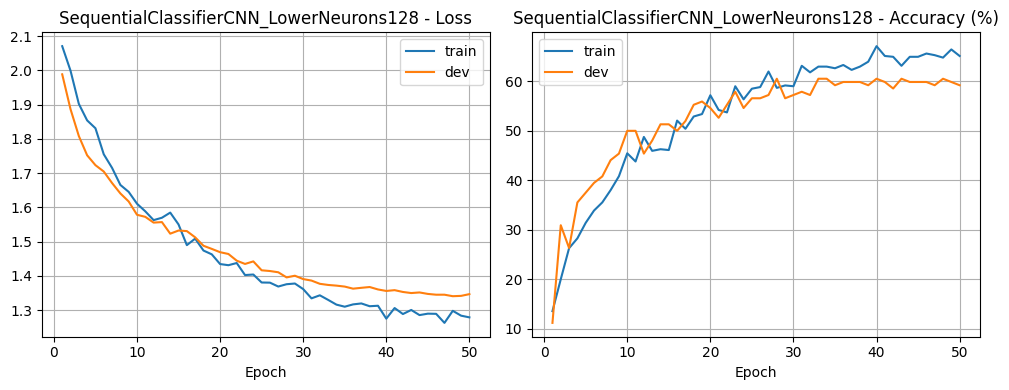

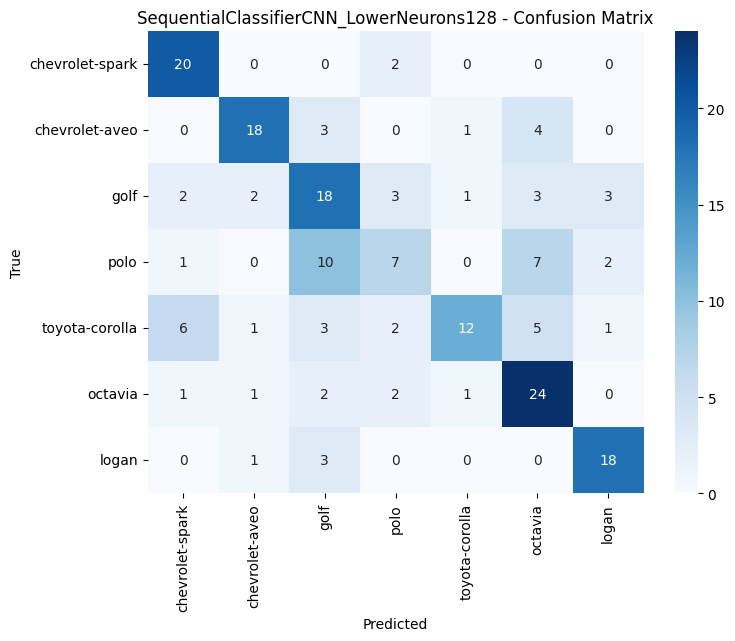

In [20]:
lower_model_params = ModelParams(
    learning_rate=1e-5,
    neurons=128,
    label="LowerNeurons128"
)

train_model(SequentialClassifierCNN, lower_model_params)

Resetting seed to: 42
Training model: SequentialClassifierCNN_Overkill
Training parameters: [learning_rate=0.0003, weight_decay=0.0001, warmup_epochs=3, training_epochs=50, patience=8, neurons=1024]
Starting training at:  2025-12-19 10:46:42
[Epoch 01 | 5.15s | p=0/8] train_loss: 1.924 | train_acc: 30.25% | dev_loss: 2.295 | dev_acc: 13.16%
[Epoch 02 | 4.05s | p=0/8] train_loss: 1.611 | train_acc: 41.98% | dev_loss: 1.621 | dev_acc: 42.76%
[Epoch 03 | 4.15s | p=1/8] train_loss: 1.519 | train_acc: 48.26% | dev_loss: 1.998 | dev_acc: 41.45%
[Epoch 04 | 4.20s | p=2/8] train_loss: 1.352 | train_acc: 56.36% | dev_loss: 2.304 | dev_acc: 33.55%
[Epoch 05 | LR] Current LR: 0.0002988172051971717
[Epoch 05 | 4.26s | p=3/8] train_loss: 1.187 | train_acc: 64.46% | dev_loss: 1.739 | dev_acc: 49.34%
[Epoch 06 | 4.19s | p=0/8] train_loss: 1.114 | train_acc: 69.59% | dev_loss: 1.160 | dev_acc: 70.39%
[Epoch 07 | 4.21s | p=1/8] train_loss: 0.982 | train_acc: 77.52% | dev_loss: 1.266 | dev_acc: 67.11%
[

C:\Users\Cristina\AppData\Local\Temp\ipykernel_22784\1521683971.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/{model_name}_b

=== FINAL TEST ACCURACY: 95.79% ===


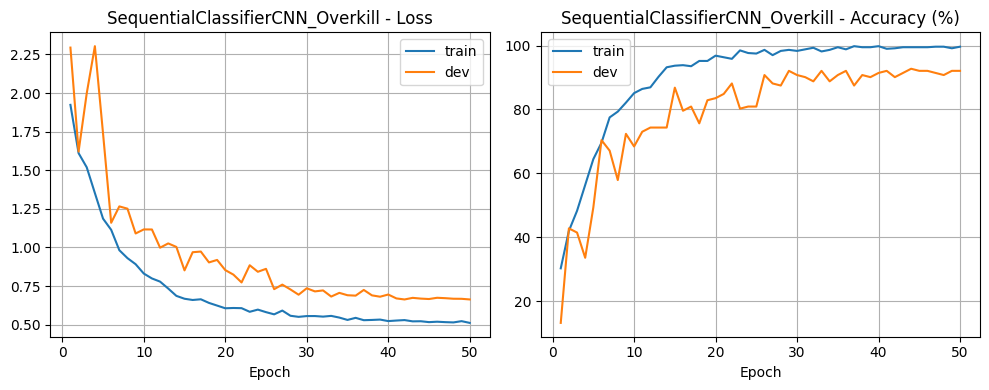

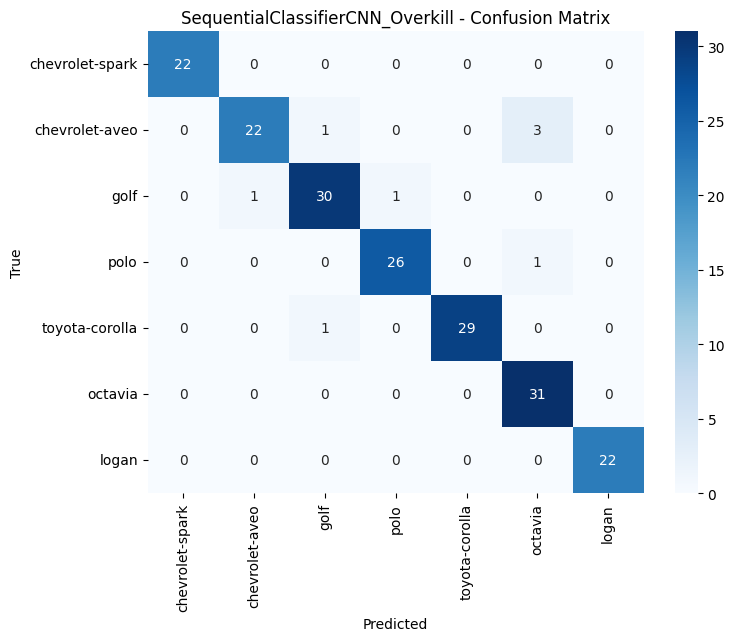

In [27]:
overkill_params = ModelParams(
    learning_rate=3e-4,
    neurons=1024,
    label="Overkill"
)

train_model(SequentialClassifierCNN, overkill_params)

Resetting seed to: 42
Training model: LimitedCNN
Training parameters: [learning_rate=0.001, weight_decay=0.0001, warmup_epochs=3, training_epochs=50, patience=8, neurons=128]
Starting training at:  2025-12-19 00:34:28
[Epoch 01 | 3.78s | p=0/8] train_loss: 1.960 | train_acc: 23.14% | dev_loss: 1.952 | dev_acc: 19.74%
[Epoch 02 | 3.98s | p=0/8] train_loss: 1.779 | train_acc: 33.72% | dev_loss: 1.738 | dev_acc: 36.18%
[Epoch 03 | 4.20s | p=0/8] train_loss: 1.655 | train_acc: 41.98% | dev_loss: 1.701 | dev_acc: 37.50%
[Epoch 04 | 3.63s | p=0/8] train_loss: 1.596 | train_acc: 42.98% | dev_loss: 1.649 | dev_acc: 39.47%
[Epoch 05 | LR] Current LR: 0.000996057350657239
[Epoch 05 | 3.88s | p=0/8] train_loss: 1.507 | train_acc: 49.75% | dev_loss: 1.610 | dev_acc: 41.45%
[Epoch 06 | 4.02s | p=1/8] train_loss: 1.478 | train_acc: 50.91% | dev_loss: 1.612 | dev_acc: 44.74%
[Epoch 07 | 4.18s | p=0/8] train_loss: 1.378 | train_acc: 56.53% | dev_loss: 1.478 | dev_acc: 49.34%
[Epoch 08 | 4.08s | p=1/8]

C:\Users\Cristina\AppData\Local\Temp\ipykernel_7980\1521683971.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/{model_name}_be

=== FINAL TEST ACCURACY: 87.37% ===


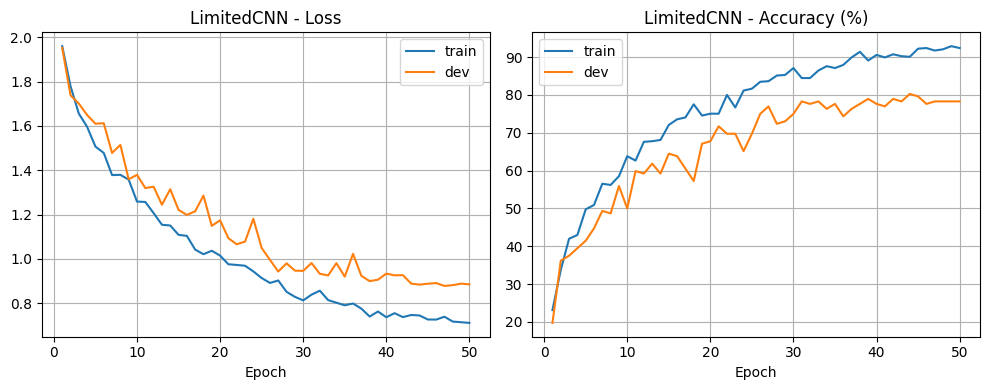

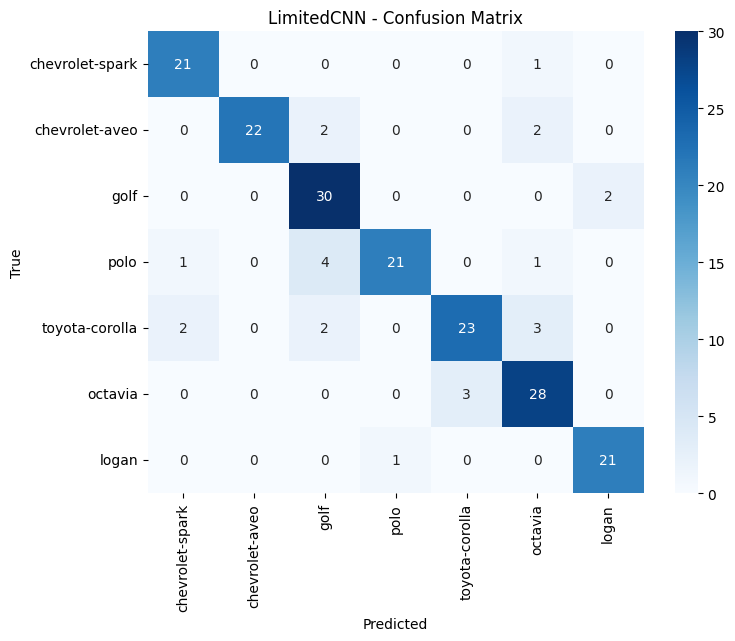

In [ ]:
limited_params = ModelParams(neurons=128)
train_model(LimitedCNN, limited_params)

Resetting seed to: 42
Training via Transfer Learning
Training model: ResNet_TransferLearning
Training parameters: [learning_rate=0.0001, weight_decay=0.0001, warmup_epochs=3, training_epochs=10, patience=8, neurons=512]
Starting training at:  2025-12-19 14:17:25
[Epoch 01 | 6.50s | p=0/8] train_loss: 2.088 | train_acc: 19.50% | dev_loss: 1.774 | dev_acc: 34.87%
[Epoch 02 | 6.56s | p=0/8] train_loss: 1.703 | train_acc: 35.04% | dev_loss: 1.382 | dev_acc: 63.16%
[Epoch 03 | 6.32s | p=0/8] train_loss: 1.225 | train_acc: 66.45% | dev_loss: 1.083 | dev_acc: 68.42%
[Epoch 04 | 6.37s | p=0/8] train_loss: 0.912 | train_acc: 80.83% | dev_loss: 0.817 | dev_acc: 84.21%
[Epoch 05 | LR] Current LR: 9.045084971874737e-05
[Epoch 05 | 6.44s | p=0/8] train_loss: 0.724 | train_acc: 91.74% | dev_loss: 0.736 | dev_acc: 86.84%
[Epoch 06 | 6.65s | p=0/8] train_loss: 0.645 | train_acc: 96.20% | dev_loss: 0.649 | dev_acc: 92.11%
[Epoch 07 | 6.62s | p=1/8] train_loss: 0.605 | train_acc: 96.20% | dev_loss: 0.67

C:\Users\felixmv\AppData\Local\Temp\ipykernel_22208\1521683971.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/{model_name}_be

=== FINAL TEST ACCURACY: 96.84% ===


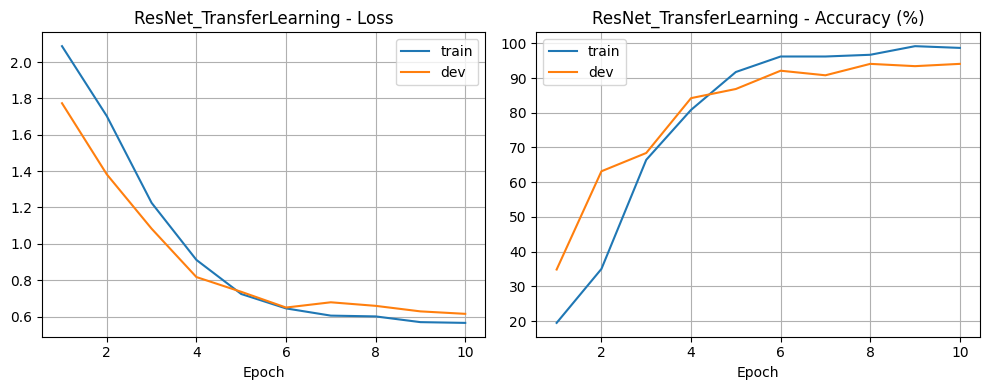

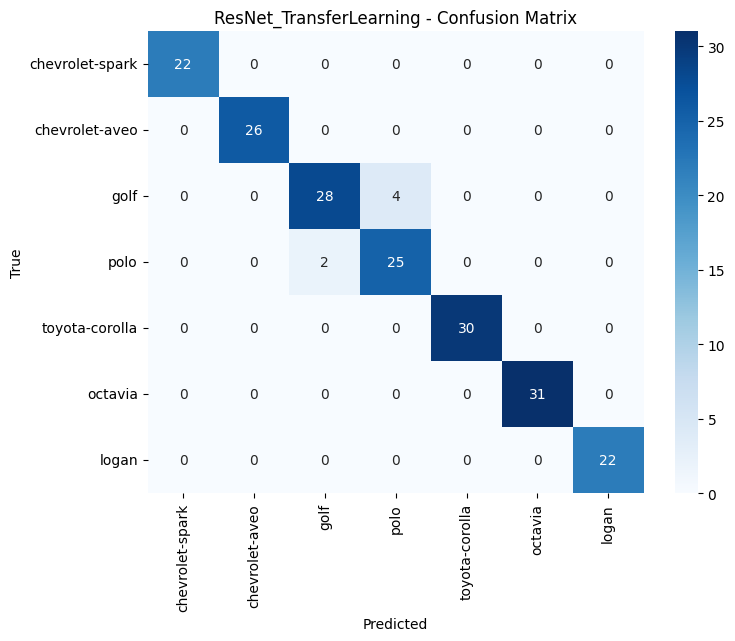

In [13]:
# -------------------- VIA TRANSFER LEARNING --------------------
pretrained_model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, len(SELECTED_CLASSES))  # ajustar la capa final
)

transfer_model_params = ModelParams(
    learning_rate=1e-4,
    warmup_epochs=3,
    training_epochs=10,
    label="TransferLearning"
)
train_model(pretrained_model, transfer_model_params, transfer_learning=True)

### Analisis de modelos `ClassifierCNN` y `SequentialClassifierCNN`

Mediante el entrenamiento de ambas redes neuronales, podemos comprobar como, independiente de la estructuracion de la arquitectura (manual o mediante el uso de `nn.Sequential`), podemos comprobar que ambas arquitecturas son matematicamente identicas (gráficas de perdida, precision y matriz de confusion identicas, con precision identica de 97.89%), y el uso de `nn.Sequential` no supone un cambio interno a la hora de entrenar el modelo, sino una ventaja a la hora de definir el modelo en el codigo. Por ello, el resto de modelos se han definido usando `nn.Sequential` para facilitar la visualizacion de los bloques individuales en la arquitectura de los distintos modelos.

Para estos modelos, podemos observar en las graficas de precision y perdida como no hay presente un overfitting preocupante: aunque la precision del entrenamiento llega casi al 100%, la validacion se mantiene muy cerca (entre 90% y 92%). Esto nos confirma como el uso de modulos como `Dropout` a 50% y `BatchNormalization` nos sirven como tecnicas de regularizacion para que el aprendizaje del modelo sea lo más estable a medida que pasan las iteraciones de entrenamiento.

Por lo tanto, podriamos concretar que, a comparativa adicional de los modelos presentados y sus resultados de precision (97.89% frente a resultados como 87.37% o 90.53%), la arquitectura de 5 bloques convolucionales es una opcion adecuada para la complejidad del problema de clasificacion, permitiendo extraer y distinguir detalles como faros, parrillas y siluetas, dotandolo de distincion detallada hasta para modelos de coches muy similares (Golf y Polo).

#### Matriz de confusion

Centrandonos en donde precisamente fallo el modelo, podemos observar que la gran mayoria de los valores de la matriz de confusion se encuentran en la diagonal, lo que reenfurza el resultado alto de precision del modelo. Sin embargo, debemos destacar las confusiones de:
- Clases "golf" y "polo": Este tipo de confusion del modelo es justificable dado que, al ser del mismo fabricante, los coches contienen piezas similares (faros, parachoques, ...), lo cual podria dificultar al modelo a la hora de distinguir entre las clases, necesitando de mayor capacidad de distincion entre caracteristicas, o mayor tiempo de entrenamiento (mayor numero de epocas superior a 50).
- Clases "chevrolet_aveo" y "chevrolet_spark": Ocurre algo similar a las clases anteriores, siendo del mismo fabricante, donde el mismo tiene cambios sutiles suficientes como para poderse categorizar como un coche distinto.

El modelo de muestra una gran capacidad de generalizacion, donde los pocos errores cometidos se concentran en clases que comparten similitudes en carroceria y diseño, lo cual es un comportamiento esperado incluso para clasificadores humanos.

#### Comparativas de `SequentialClassifierCNN` y sus variantes `LowerNeurons256, LowerNeurons128, Overkill`

| Modelo                  | Neuronas (Capa Oculta) | Tasa de Aprendizaje (LR) | Precisión Final (Test) | Estado                          |
|-------------------------|-----------------------|----------------------------|------------------------|---------------------------------|
| SequentialClassifierCNN (Base) | 512                   | 1e-3                       | 97.89%                 | Mejor precision                            |
| Overkill                | 1024                  | 3e-4                       | 95.79%                 | Sobre-dimensionado              |
| Lower256                | 256                   | 1e-4                       | 90.53%                 | Sub-dimensionado (Leve)         |
| Lower128                | 128                   | 1e-5                       | 61.58%                 | Cuello de Botella (Severo)      |

En primer lugar, atendiendo a los modelos `Lower256, Lower128`, podemos observar que con 128 neuronas en la capa oculta, el rendimiento cae drasticamente. Esto ocurre dado que estamos forzando a la red a comprimir toda la informacion del coche extraida en las 5 capas convolutivas a solo 128 neuronas, perdiendo informacion clave para su distincion. Podriamos decir que no cabe toda la informacion necesaria en las 128 neuronas, imposibilitando una distincion certera entre clases similares como Golf y Polo. Otro parámetro por el cual se pudo ver afectado el rendimiento del modelo seria el *learning rate*, del cual puesto muy bajo a `1e-5` requeriria más tiempo de entrenamiento y culminar en resultados pobres en solo 50 iteraciones. 

Por otra parte, podemos ver que el modelo `Lower256` obtiene resultados aceptables teniendo de referencia nuestro modelo de mejor precision (90.53% vs 97.89%). Aunque su rendimiento es inferior, podemos destacar que una capa oculta con 256 neuronas sirve como limite inferior, empezando a sufrir consecuencias para representar todas las caracteristicas necesarias.

En el caso del modelo `Overkill`, podemos destacar que no siempre un mayor numero de neuronas y aprendizaje rapido culmina en mejores resultados. Al duplicar las neuronas a 1024, el modelo es ahora más propenso a *Overfitting*: el modelo memoriza el ruido dentro del set de entrenamiento en lugar de aprender patrones que lo ayuden a generalizar. El modelo supone una desventaja directa de menor precision a mayor coste computacional.

### Analisis del modelo `LimitedCNN`

Este modelo al disponer de menos capas de convolucion y el ancho de los canales de salida (64 a diferencia de 512), la red no pudo desarrollar una capacidad completa para diferenciar con detalle las distintas carrocerías. Esto es un caso de *Underfitting*: el modelo no tiene los suficientes parámetros para aprender los patrones complejos necesarios para diferenciar un coche con otro en alta precision. Esto reenfuerza la necesidad de las 5 capas convolutivas con 512 canales de salida, marcando una arquitectura suficiente para poder detallar aquellos detalles más pequeños distintos entre los coches. 

### Analisis de entrenamiento via aprendizaje por transferencia

El aprendizaje por transferencia se ha ejecutado a partir del modelo ResNet18: un modelo de redes neuronales convolucionales con 18 capas de profundidad. Este modelo dispone de un gran numero de capas gracias a las "conexiones residuales". Estas conexiones residuales o skip connections permite que la informacion salte entre capas y sume directamente al resultado de estas. A diferencia de un modelo tradicional donde la informacion atraviesa las capas del modelo, si se equivoca, el resultado correcto se podria perder. En ResNet, las skip connections permiten que la informacion llegue al final tanto la procesada como la original, asegurando que en el peor de los casos, no se pierda la informacion original.

Usando ResNet18, sustituimos la ultima capa fully connected con una capa de salida con nuestro numero de clases y un `Dropout` de `0.5`.

Dado que ResNet18 ya se ha entrenado previamente con el dataset ImageNet (1.2 millones de imágenes y 1000 categorias), el modelo no parte de cero, y ya sabe distinguir entre bordes, materiales y formas. El proceso por el que pasamos el aprendizaje se llama *fine-tuning*, donde refinamos un modelo existente con datos especificos para que se ajuste a nuestras necesidades.

En nuestro caso, podemos ver que con nada más 10 iteraciones de entrenamiento, ya obtenemos un 96.84% de precision, a diferencia de 50 epocas de entrenamiento en los modelos que parten de cero. Observando la matriz de confusion, podemos apuntar como el modelo aun confunde clases como `Golf` y `Polo`, lo cual se debe a razones previamente explicadas (mismo fabricante, mismas piezas reutilizadas). Podriamos concluir que estos errores vuelven a ser un comportamiento esperado incluso para clasificadores humanos.

Cabe destacar que para este proceso de *fine-tuning*, debemos entrenar el modelo a una tasa de aprendizaje más baja de la habitual (`1e-4`en vez de `1e-3`), dado que el ya ha pasado por un proceso de aprendizaje y no necesita una tasa de aprendizaje tan agresiva a estas alturas del proceso de aprendizaje del modelo.

### Uso de Average Pooling y diferencias con Max Pooling

El `Average Pooling` es una operacion que tambien se utiliza en redes neuronales convolucionales (CNN) cuyo objetivo es reducir las dimensiones de los mapas de caracteristicas. La tecnica tiene como principal objetivo dividir la imagen en ventanas y calcula el promedio de los valores dentro de cada region para así conservar información global de la imagen mientras se va reduciendo el tamaño espacial. Su uso es comun cuando se desea mantener una representacion mas suave y general de las caracteristicas, haciendolo menos sensible al ruido y a los valores externos.

Por otro lado, `Max Pooling` tambien reduce la dimensionalidad, pero selecciona el valor maximo dentro de cada ventana, pudiendo resaltar las caracteristicas más relevantes, como los bordes o patrones importantes. 

Con estas definiciones podemos deducir que el `Max Pooling` tendra mejor precision debido a que nuestra red neuronal require priorizar bordes y caracteristicas unicas de cada modelo de coche. Aún asi, haremos la arquitectura de un modelos con `Average Pooling` para poder corroborarlo.

#### Adaptative Average Pooling o Average Pooling

Ambos son tecnicas de *pooling* para reducir la dimensionalidad de los mapas de caracteristicas. La principal diferencia es la *diferencia visual*. `AvgPool2d` se utiliza para ir reduciendo el tamaño espacial, donde el tamaño de salida dependera del tamaño de entrada, esto no ocurre con `AdapativeAvgPool` ya que se usa una sola vez al final y se ajusta automaticamente el tamaño del kernel y stride para mostrar como salida unas dimensiones específicas, independientemente del tamaño.

In [20]:
class AveragePoolingCNN(nn.Module):
    def __init__(self, neurons):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 224 -> 112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 112 -> 56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 56 -> 28

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 28 -> 14
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14 -> 7
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * (IMAGE_SIZE // 32) * (IMAGE_SIZE // 32), neurons),
            nn.BatchNorm1d(neurons),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(neurons, len(SELECTED_CLASSES)),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

Resetting seed to: 42
Training model: AveragePoolingCNN2_AveragePooling2
Training parameters: [learning_rate=0.001, weight_decay=0.0001, warmup_epochs=3, training_epochs=50, patience=8, neurons=128]
Starting training at:  2025-12-19 00:49:12
[Epoch 01 | 4.21s | p=0/8] train_loss: 1.984 | train_acc: 22.31% | dev_loss: 1.970 | dev_acc: 19.08%
[Epoch 02 | 4.26s | p=0/8] train_loss: 1.849 | train_acc: 27.11% | dev_loss: 1.844 | dev_acc: 26.97%
[Epoch 03 | 4.08s | p=1/8] train_loss: 1.764 | train_acc: 34.55% | dev_loss: 1.850 | dev_acc: 23.68%
[Epoch 04 | 4.30s | p=0/8] train_loss: 1.743 | train_acc: 35.70% | dev_loss: 1.784 | dev_acc: 31.58%
[Epoch 05 | LR] Current LR: 0.000996057350657239
[Epoch 05 | 4.22s | p=0/8] train_loss: 1.673 | train_acc: 39.83% | dev_loss: 1.668 | dev_acc: 41.45%
[Epoch 06 | 4.23s | p=1/8] train_loss: 1.612 | train_acc: 41.82% | dev_loss: 1.765 | dev_acc: 34.21%
[Epoch 07 | 4.19s | p=0/8] train_loss: 1.547 | train_acc: 46.78% | dev_loss: 1.572 | dev_acc: 41.45%
[E

C:\Users\Cristina\AppData\Local\Temp\ipykernel_7980\1521683971.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/{model_name}_be

=== FINAL TEST ACCURACY: 72.63% ===


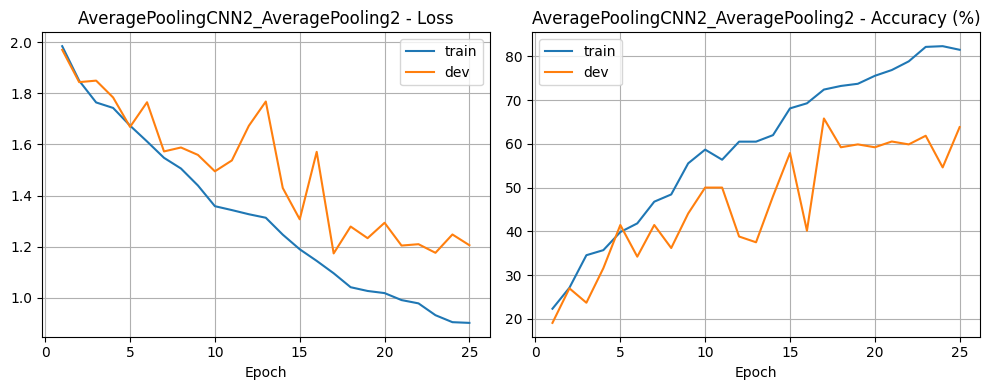

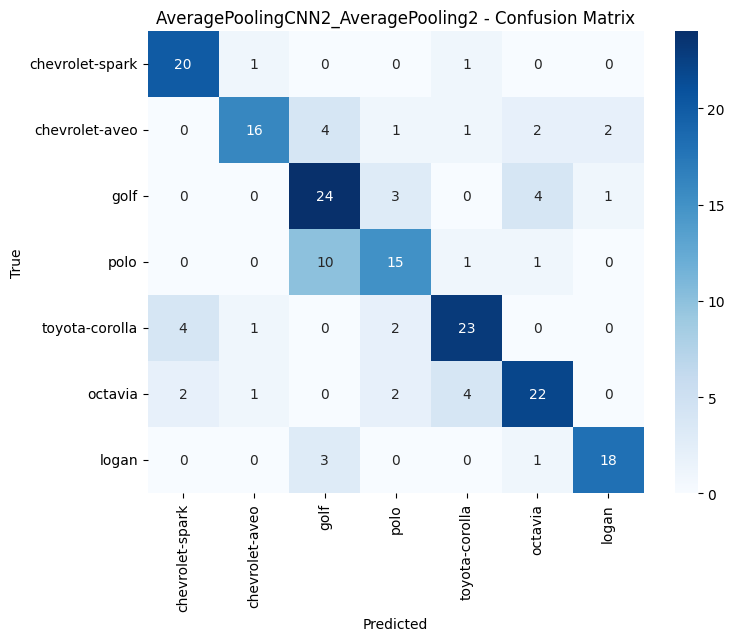

In [ ]:
AveragePooling_params2 = ModelParams(
    learning_rate=1e-3, 
    neurons=128,
    label="AveragePooling2"
)
train_model(AveragePoolingCNN, AveragePooling_params2)

Resetting seed to: 42
Training model: AveragePoolingCNN2_AveragePooling2
Training parameters: [learning_rate=0.0001, weight_decay=0.0001, warmup_epochs=3, training_epochs=50, patience=8, neurons=128]
Starting training at:  2025-12-15 13:02:02
[Epoch 01 | 4.10s | p=0/8] train_loss: 1.990 | train_acc: 19.50% | dev_loss: 1.975 | dev_acc: 11.84%
[Epoch 02 | 4.03s | p=0/8] train_loss: 1.846 | train_acc: 27.11% | dev_loss: 1.826 | dev_acc: 29.61%
[Epoch 03 | 4.02s | p=0/8] train_loss: 1.756 | train_acc: 33.88% | dev_loss: 1.723 | dev_acc: 36.18%
[Epoch 04 | 3.97s | p=0/8] train_loss: 1.669 | train_acc: 39.83% | dev_loss: 1.657 | dev_acc: 44.08%
[Epoch 05 | LR] Current LR: 9.96057350657239e-05
[Epoch 05 | 3.96s | p=0/8] train_loss: 1.625 | train_acc: 43.80% | dev_loss: 1.600 | dev_acc: 45.39%
[Epoch 06 | 3.92s | p=0/8] train_loss: 1.503 | train_acc: 52.07% | dev_loss: 1.587 | dev_acc: 48.68%
[Epoch 07 | 3.94s | p=0/8] train_loss: 1.469 | train_acc: 55.21% | dev_loss: 1.531 | dev_acc: 46.71%
[

C:\Users\Cristina\AppData\Local\Temp\ipykernel_30464\1521683971.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/{model_name}_b

=== FINAL TEST ACCURACY: 86.32% ===


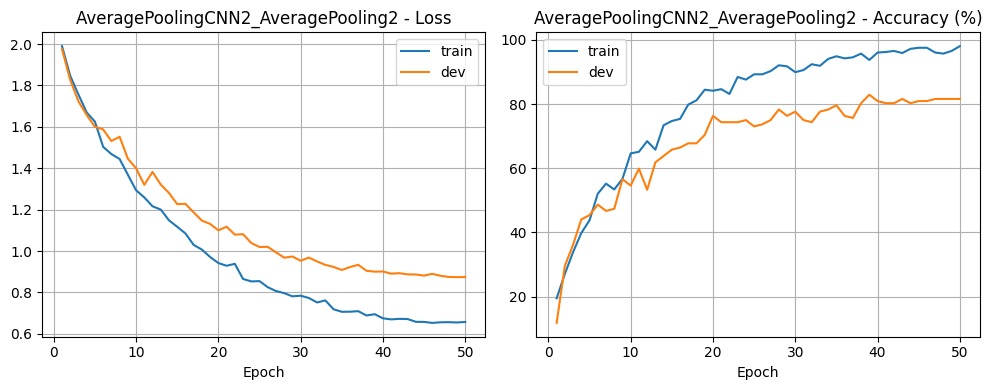

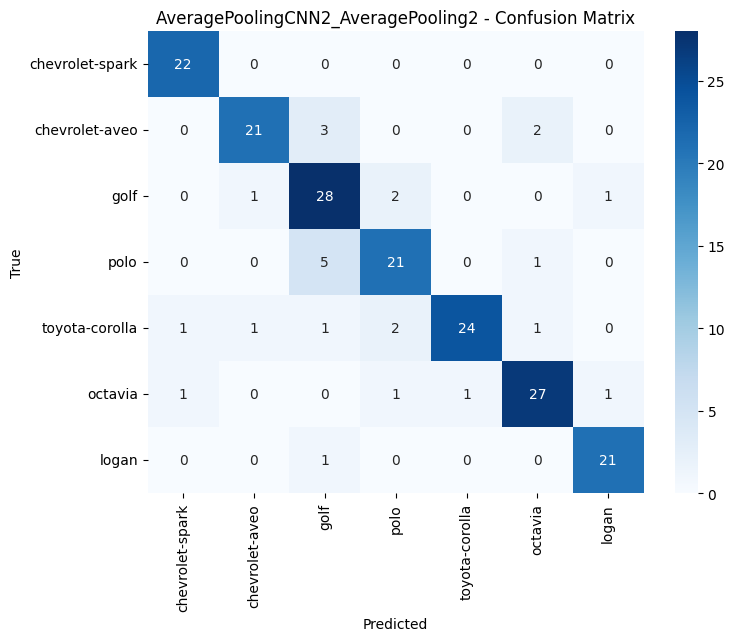

In [ ]:
AveragePooling_params2 = ModelParams(
    learning_rate=1e-4, neurons=128, label="AveragePooling2"
)
train_model(AveragePoolingCNN, AveragePooling_params2)

In [37]:
class AdaptativeAveragePooling_andMaxPoolingCNN(nn.Module):
    def __init__(self, neurons):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 224 -> 112
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 112 -> 56
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 56 -> 28
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28 -> 14
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((2, 2)),  # 14 -> 7
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, neurons),
            nn.BatchNorm1d(neurons),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(neurons, len(SELECTED_CLASSES)),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

Resetting seed to: 42
Training model: AdaptativeAveragePooling_andMaxPoolingCNN
Training parameters: [learning_rate=0.001, weight_decay=0.0001, warmup_epochs=3, training_epochs=50, patience=8, neurons=512]
Starting training at:  2025-12-19 01:01:57
[Epoch 01 | 4.22s | p=0/8] train_loss: 1.970 | train_acc: 21.98% | dev_loss: 2.188 | dev_acc: 13.82%
[Epoch 02 | 4.35s | p=0/8] train_loss: 1.883 | train_acc: 28.93% | dev_loss: 1.826 | dev_acc: 32.89%
[Epoch 03 | 4.29s | p=1/8] train_loss: 1.874 | train_acc: 26.45% | dev_loss: 1.970 | dev_acc: 31.58%
[Epoch 04 | 4.45s | p=2/8] train_loss: 1.792 | train_acc: 29.42% | dev_loss: 1.949 | dev_acc: 25.66%
[Epoch 05 | LR] Current LR: 0.000996057350657239
[Epoch 05 | 4.35s | p=3/8] train_loss: 1.729 | train_acc: 37.36% | dev_loss: 2.241 | dev_acc: 26.32%
[Epoch 06 | 4.36s | p=4/8] train_loss: 1.706 | train_acc: 36.53% | dev_loss: 2.143 | dev_acc: 26.32%
[Epoch 07 | 4.15s | p=0/8] train_loss: 1.633 | train_acc: 40.33% | dev_loss: 1.804 | dev_acc: 34

C:\Users\Cristina\AppData\Local\Temp\ipykernel_7980\1521683971.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/{model_name}_be

=== FINAL TEST ACCURACY: 91.05% ===


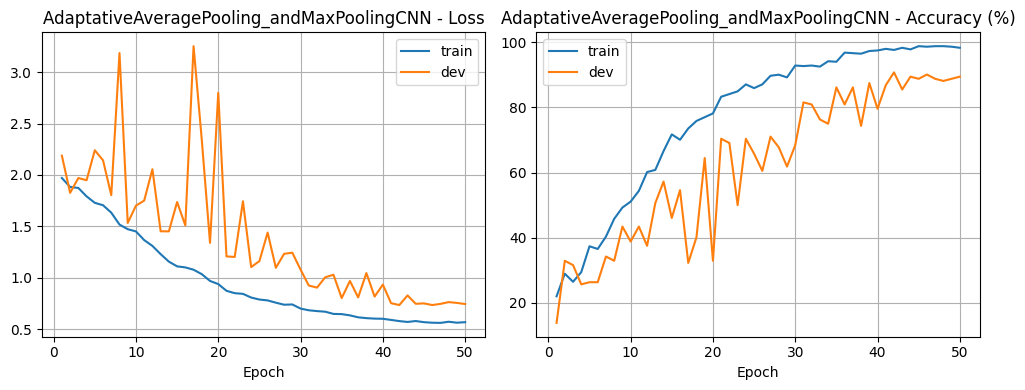

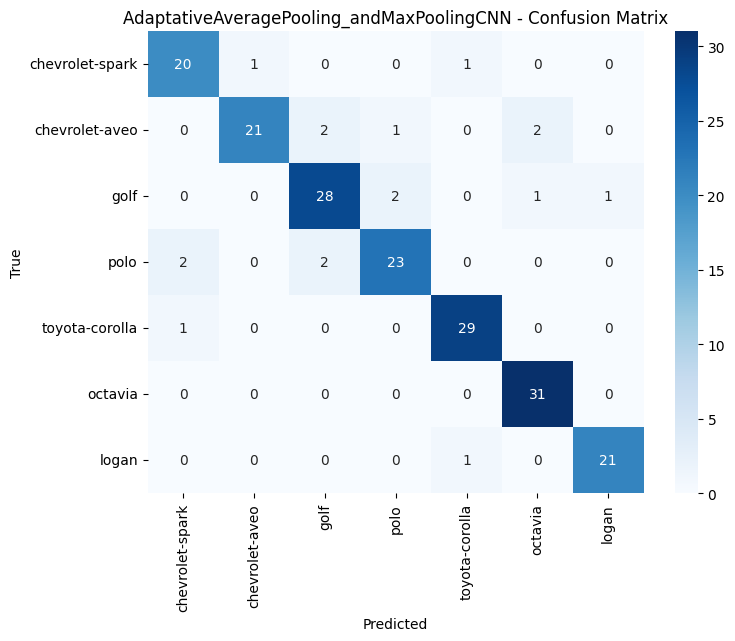

In [ ]:
train_model(AdaptativeAveragePooling_andMaxPoolingCNN, DEFAULT_MODEL_PARAMS)

Resetting seed to: 42
Training model: AdaptativeAveragePooling_andMaxPoolingCNN_LowerNeurons256
Training parameters: [learning_rate=0.0001, weight_decay=0.0001, warmup_epochs=3, training_epochs=50, patience=8, neurons=256]
Starting training at:  2025-12-19 11:10:13
[Epoch 01 | 4.22s | p=0/8] train_loss: 2.017 | train_acc: 17.85% | dev_loss: 1.958 | dev_acc: 15.13%
[Epoch 02 | 4.45s | p=0/8] train_loss: 1.855 | train_acc: 26.45% | dev_loss: 1.814 | dev_acc: 32.24%
[Epoch 03 | 4.55s | p=0/8] train_loss: 1.817 | train_acc: 29.92% | dev_loss: 1.781 | dev_acc: 26.97%
[Epoch 04 | 4.59s | p=1/8] train_loss: 1.770 | train_acc: 34.05% | dev_loss: 1.789 | dev_acc: 29.61%
[Epoch 05 | LR] Current LR: 9.96057350657239e-05
[Epoch 05 | 4.48s | p=0/8] train_loss: 1.713 | train_acc: 35.21% | dev_loss: 1.777 | dev_acc: 33.55%
[Epoch 06 | 4.84s | p=0/8] train_loss: 1.688 | train_acc: 37.85% | dev_loss: 1.694 | dev_acc: 39.47%
[Epoch 07 | 4.38s | p=0/8] train_loss: 1.581 | train_acc: 44.13% | dev_loss: 1.

C:\Users\Cristina\AppData\Local\Temp\ipykernel_1432\1521683971.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/{model_name}_be

=== FINAL TEST ACCURACY: 80.00% ===


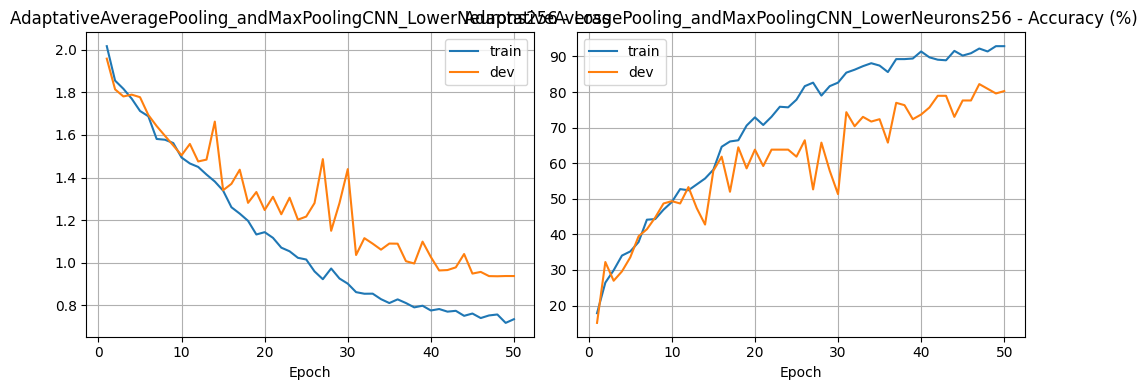

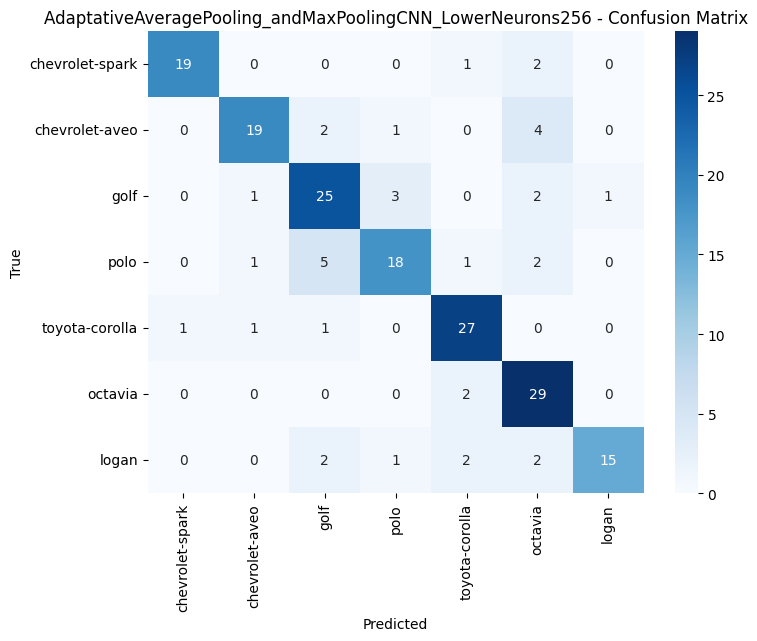

In [21]:
train_model(AdaptativeAveragePooling_andMaxPoolingCNN, low_model_params)


### Comparativa de los modelos AdaptativeAveragePooling con MaxPooling y AveragePooling

En la fase final del estudio, observaremos el rendimiento del modelo basado en el modelo `AveragePooling` usando los componentes `MaxPooling` y `AvgPooling`, mostrando como la capacidad de la red para clasificar vehículos correctamente influye en la estrategia de pooling.

| Modelo                  | Neuronas (Capa Oculta) | Tasa de Aprendizaje (LR) | Precisión Final (Test) | Estado                          |
|-------------------------|-----------------------|----------------------------|------------------------|---------------------------------|
| AdaptativeAveragePooling and MaxPoolingCNN                 | 512                   | 1e-3                       | 91.05%                 |  Mejor precisión       |
| AdaptativeAveragePooling and MaxPoolingCNN low   model param              | 256                   | 1e-4                       | 80%                 |   Sub-dimensionado (menos agresivo)   |
| AveragePoolingCNN low lr              | 128                  | 1e-4                       | 86.32%                 |       Cuello de Botella (Severo)          |
| AveragePoolingCNN  | 128                   | 1e-3                       |  72.63%                 | Sobre-dimensionado                           |


Comentando sobre el uso de `AveragePooling` y el `AveragePoolingCNN low lr`, hemos creado dos modelos: uno con menor *learning rate* y otro con un valor de *learning rate* mayor, así poder conocer su rendimiento. 

El modelo de `AveragePooling` muestra limitaciones debido al uso de `AvgPool2d`, dandonos una perdida en la extraccion de detalles, una cualidad importante dentro de nuestro dataset, con una inestabilidad observada con el aconstecimiento del *overfitting* debido a una tasa de aprendizaje alta en una red estrecha de 128 neuronas. Viendo que a medida que el modelo se entranaba, tanto la perdida como la precision de validación mejora de forma agresiva, evitando un entrenamiento estable. Aun asi, en el modelo de `AveragePoolingCNN low lr` podemos observar que se mantuvo el mismo número de neuronas cambiando la tasa de aprendizaje a una más baja, consiguiendo así una red que no obtuvo el impulso para aprender originando un cuello de botella en el numero de neuronas capaces de procesar la abundancia de informacion. 

#### Analisis del modelo `AdaptativeAveragePooling`

El modelo base que parte de la combinación entre `MaxPooling` y `AvgPooling`, `AdaptativeAveragePooling`, obtiene una mejor precision con los parámetros por defecto: 512 neuronas y un *learing rate* de 1e-3. Esto es gracias al `MaxPooling`, el componente que permite que la red retenga los rasgo más prominentes del vehículo y descartar el ruido de fondo de forma drastica (por maximos) para detectar formas y bordes, usando de ultimo el componente `AdaptativeAvgPooling` el cual nos permite al final de la red una extracción de caracteristicas suavizada, dandonos una generalizacion de detalles suavizada antes de pasar a la clasificación. 

El principal inconveniente con el modelo `AdaptativeAveragePooling` en comparacion con los valores y graficas obtenidas en el modelo `SequentialClassifierCNN` es que el uso de `AveragePooling` suaviza los detalles del dataset, complicando a la red poder visualizar las caracterísitcas diferenciales del coche. Esto se puede observar en la matriz de confusión del modelo. Cuando usamos `AdaptativeAveragePooling` podemos observar como se confunde entre un carroceria *polo* y un *chevrolet-spark*, lo cual no ocurre con el modelo `SequentialClassifierCNN`.

En conclusión, el `SequentialClassifierCNN` prioriza la existencia de rasgos distintivos gracias al componente `MaxPool`, mientras que el modelo con `AdaptativeAvgPooling` prioriza la consistencia global. En un dataset como el que estamos trabajando de clasificación de coches, la diferencia entre las carrocerias suele reducirse en detalles sutiles como son los faros y parachoques, lo que conlleva que elegir un modelo donde nos da el promedio y suaviza los detalles es contraproducente, ya que provoca que la red no conozca las pequeñas variaciones.